# Explainable recommendation
## Attentive Multitask Collaborative Filtering (AMCF) model

In [11]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_amcf import get_data, item_to_genre


In [2]:
# load model
model = torch.load('AMCF_model_13f_20181231.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

AMCF(
  (user_emb): Embedding(70112, 256)
  (item_emb): Embedding(2307, 256)
  (asp_emb): Aspect_emb()
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=13, bias=True)
  )
  (pdist): PairwiseDistance()
)

In [3]:
# get user overall preference of each aspects
users = torch.tensor(range(943), dtype=torch.long).to(device)
u_pred = model.predict_pref(users)
print(u_pred, u_pred.shape)

tensor([[ 0.0915, -0.0329, -0.1765,  ..., -0.0714, -0.0731, -0.1331],
        [-0.0248, -0.1450,  0.1413,  ...,  0.0898,  0.0208, -0.0440],
        [ 0.1355,  0.0432, -0.0840,  ...,  0.0766,  0.0628,  0.0813],
        ...,
        [ 0.0403,  0.0221,  0.0219,  ...,  0.1655, -0.1124, -0.0132],
        [-0.0715,  0.0461,  0.1379,  ...,  0.0218, -0.0784,  0.1103],
        [ 0.0293, -0.0648, -0.0069,  ..., -0.1824, -0.1294,  0.0631]],
       device='cuda:0', grad_fn=<DivBackward0>) torch.Size([943, 13])


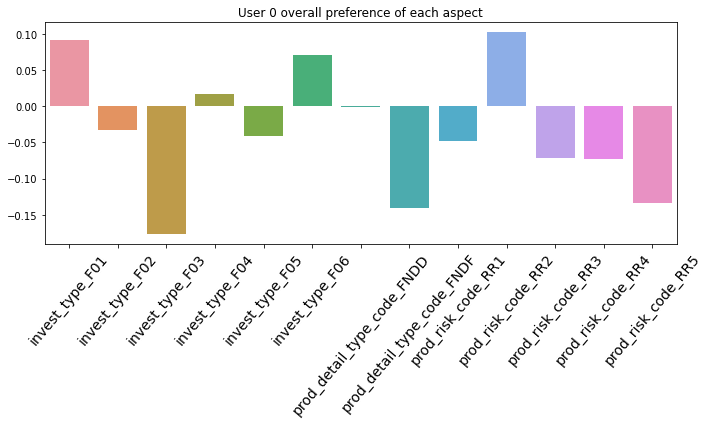

In [34]:
def plot_upref(uid, u_pred):
    df = pd.DataFrame(u_pred[0].cpu().detach().numpy())
    aspects = ['wm_prod_code', 'invest_type_F01', 'invest_type_F02', 'invest_type_F03',
       'invest_type_F04', 'invest_type_F05', 'invest_type_F06',
       'prod_detail_type_code_FNDD', 'prod_detail_type_code_FNDF',
       'prod_risk_code_RR1', 'prod_risk_code_RR2', 'prod_risk_code_RR3',
       'prod_risk_code_RR4', 'prod_risk_code_RR5']
    plt.figure(figsize=(10,6))
    sns.barplot(x=aspects[1:], y=u_pred[uid].cpu().detach().numpy(), data=df)
    plt.title('User '+str(uid)+' overall preference of each aspect')
    plt.xticks(rotation=50, fontsize=14)
    plt.tight_layout()
    plt.savefig('overall_pref_bar.png')

plot_upref(0, u_pred)

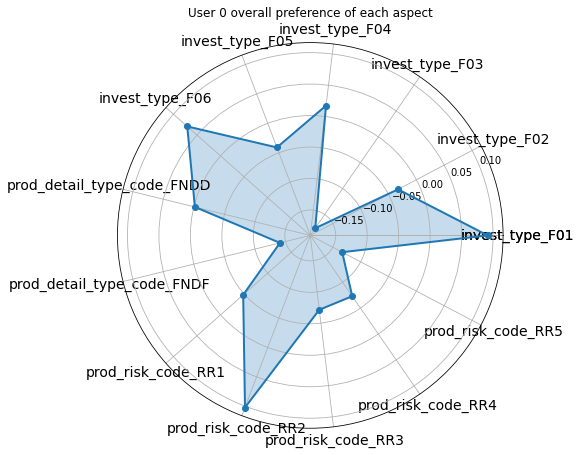

In [32]:
def plot_upref_radar(uid, u_pred):
    stats = u_pred[uid].cpu().detach().numpy()
    aspects = np.array(['invest_type_F01', 'invest_type_F02', 'invest_type_F03',
       'invest_type_F04', 'invest_type_F05', 'invest_type_F06',
       'prod_detail_type_code_FNDD', 'prod_detail_type_code_FNDF',
       'prod_risk_code_RR1', 'prod_risk_code_RR2', 'prod_risk_code_RR3',
       'prod_risk_code_RR4', 'prod_risk_code_RR5'])
    
    angles=np.linspace(0, 2*np.pi, len(aspects), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    aspects=np.concatenate((aspects,[aspects[0]]))
    ax.set_thetagrids(angles * 180/np.pi, aspects, fontsize=14)
    ax.set_title('User '+str(uid)+' overall preference of each aspect')
    ax.grid(True)
    plt.tight_layout()
    plt.savefig('overall_pref_radar.png')

plot_upref_radar(0, u_pred)

tensor([[-0.2616,  0.1491,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.6849,
          0.0000,  0.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>) torch.Size([1, 18])


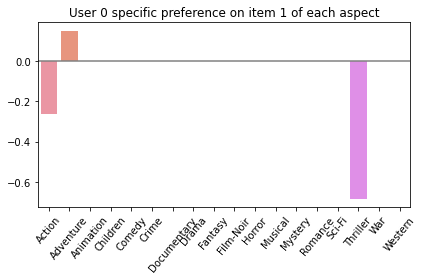

In [10]:
def plot_ui_spec_pref(uid, iid):
    # get user specific preference on item j of each aspects
    users = torch.tensor([uid], dtype=torch.long).to(device)
    items = torch.tensor([iid], dtype=torch.long).to(device)
    # get genre information from item id
    item_asp = item_to_genre(items.cpu(), data_size='100k').values
    item_asp = torch.Tensor(item_asp).to(device)
    ui_pred = model.predict_spec_pref(users, items, item_asp)
    print(ui_pred, ui_pred.shape)

    aspects = pd.read_csv('/home/cytsao/esun_fund/AMCF_original/movielens/ml-100k.movies').columns
    sns.barplot(x=aspects[1:], y=ui_pred.cpu().detach().numpy()[0])
    plt.title('User '+str(uid)+' specific preference on item '+str(iid)+' of each aspect')
    plt.xticks(rotation=50)
    plt.axhline(0, color='gray')
    plt.tight_layout()
    # plt.savefig('spec_pref.png')


plot_ui_spec_pref(0, 1)